## Loading and Preparation of Dataset

In [1]:
# Imports
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision
import numpy as np
import torch.nn as nn
from torchvision import models
import torch.optim as optim
import torchvision.transforms.functional as F

In [ ]:
# Define dataset path and get folder names as labels
data_path = "./Data/Aerial_Landscapes"
labels = categories = os.listdir(data_path)
print(labels)
image_paths = []
image_labels = []

# Traverse dataset directory and get all image files in folders
for label in labels:
    folder_path = os.path.join(data_path, label)
    for image_file in os.listdir(folder_path):
        image_paths.append(os.path.join(folder_path, image_file))
        image_labels.append(label)

# Print middle image path and label
print(f'Image Path: {image_paths[0]} | Label: {image_labels[0]}')

# Check if image_paths and image_labels are the same length
print(f'Total images: {len(image_paths)}, Total labels: {len(image_labels)}')

['Agriculture', 'Airport', 'Beach', 'City', 'Desert', 'Forest', 'Grassland', 'Highway', 'Lake', 'Mountain', 'Parking', 'Port', 'Railway', 'Residential', 'River']
Image Path: ./Data/Aerial_Landscapes\Agriculture\001.jpg | Label: Agriculture
Total images: 12000, Total labels: 12000


In [3]:
# Create a LabelEncoder to convert labels to integers
label_encoder = LabelEncoder()
label_encoder.fit(labels)  # Fit encoder to all unique labels

# Convert image labels to integer indices
image_labels = label_encoder.transform(image_labels)

In [ ]:
# Custom Dataset Class for this task
class ImageDataset(Dataset):
    # Initialize the dataset with image paths, labels, and optional transformations
    def __init__(self, image_paths, image_labels, transform=None):
        self.image_paths = image_paths
        self.image_labels = image_labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        image = Image.open(self.image_paths[idx]).convert('RGB')

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        # Get label
        label = self.image_labels[idx]

        return image, label

In [5]:
# Create a temporary dataset to calculate the mean and std
basic_transform = transforms.Compose([transforms.ToTensor()])

temp_dataset = ImageDataset(image_paths, image_labels, transform=basic_transform)
temp_loader = DataLoader(temp_dataset, batch_size=64, shuffle=False, num_workers=0)

# Calculate mean and std
mean = 0.0
std = 0.0
total_images = 0

for images, _ in temp_loader:
    images = images.view(images.size(0), images.size(1), -1)  # Flatten each image batch
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    total_images += images.size(0)

mean /= total_images
std /= total_images

print("Calculated Mean:", mean)
print("Calculated Std:", std)

Calculated Mean: tensor([0.3781, 0.3930, 0.3445])
Calculated Std: tensor([0.1353, 0.1230, 0.1177])


In [6]:
# Split into train and temp (validation + test) sets
train_paths, temp_paths, train_labels, temp_labels = train_test_split(image_paths, image_labels, test_size=0.3, stratify=image_labels, random_state=42)

# Split temp into validation and test sets
val_paths, test_paths, val_labels, test_labels = train_test_split(temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)

# Print the sizes of each set
print(f'Training set size: {len(train_paths)}')
print(f'Validation set size: {len(val_paths)}')
print(f'Test set size: {len(test_paths)}')
# 70% training, 15% validation, and 15% test data.

Training set size: 8400
Validation set size: 1800
Test set size: 1800


In [7]:
# Define the transform using the calculated mean and std
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 pixels (adjust as needed)
    transforms.ToTensor(),          # Convert image to tensor
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())  # Normalize with calculated mean and std
])

In [8]:
# Create datasets
train_dataset = ImageDataset(train_paths, train_labels, transform=transform)
val_dataset = ImageDataset(val_paths, val_labels, transform=transform)
test_dataset = ImageDataset(test_paths, test_labels, transform=transform)

In [ ]:
# Hyperparameters
batch_size = 64 # Lowered to 64 because of VGG16 memory usage
num_workers = 0 # Must be 0 or else program freezes. Issue might be windows or jupyter notebook instead of .py file.

In [10]:
# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

Data loaded successfully!


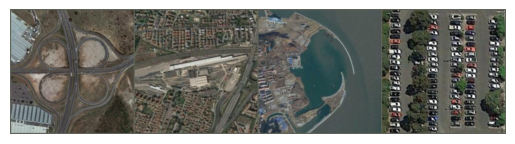

Labels:  Highway Railway Port Parking


In [12]:
# Function to unnormalize and visualize a batch of images
def imshow(img, mean, std):
    # Unnormalize the image
    img = img * std[:, None, None] + mean[:, None, None]  # Reshape mean and std for broadcasting
    img = np.clip(img, 0, 1)  # Clip to [0, 1] to avoid clipping warnings
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')  # Hide axes
    plt.show()

# Get a batch of training data, if working correctly (had some problems)
try:
    dataiter = iter(train_loader)
    images, label = next(dataiter)
    print("Data loaded successfully!")
except Exception as e:
    print(f"Error loading data: {e}")

# Define mean and std for unnormalization
mean = torch.tensor([0.3781, 0.3930, 0.3445])
std = torch.tensor([0.1353, 0.1230, 0.1177])

# Select a batch of 4 images and labels
image_batch = images[0:4]
label_batch = label[0:4]

# Show the 4 images
imshow(torchvision.utils.make_grid(image_batch), mean, std)

# Print the labels for the current batch of images
print('Labels: ', ' '.join(f'{labels[j]}' for j in label_batch))

## Loading Models with Pretrained and Random Weights

In [25]:
# Set number of output classes
num_classes = 15

# Load pretrained AlexNet model
AlexNet_default = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)
AlexNet_random = models.alexnet()

# Load pretrained VGG16 model
VGG16_default = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
VGG16_random = models.vgg16()

# Load pretrained ResNet34 model
ResNet34_default = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
ResNet34_random = models.resnet34()

# Change number of output classes to 15
AlexNet_default.classifier[6] = nn.Linear(AlexNet_default.classifier[6].in_features, num_classes)
AlexNet_random.classifier[6] = nn.Linear(AlexNet_random.classifier[6].in_features, num_classes)
VGG16_default.classifier[6] = nn.Linear(VGG16_default.classifier[6].in_features, num_classes)
VGG16_random.classifier[6] = nn.Linear(VGG16_random.classifier[6].in_features, num_classes)
ResNet34_default.fc = nn.Linear(ResNet34_default.fc.in_features, num_classes)
ResNet34_random.fc = nn.Linear(ResNet34_random.fc.in_features, num_classes)

In [11]:
# Decide if the calculations are perfomed by GPU or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Selected device: {device}")

# Cross Entropy Loss for multi-class classification
criterion = nn.CrossEntropyLoss()

''' L2 Regularization adds a penalty proportional to the square of the magnitude
 of the weights to the loss function. Discourages the model from assigning
  too much importance to any individual feature by keeping the weights small.
 The larger the weight, the higher the penalty.'''
# Learning rate and weight decay (L2 regularization)
lr = 0.0001
weight_decay = 0.0005

Selected device: cuda


## Define Training function
This function returns training and validation loss and accuracy and saves resultant model

In [27]:
def training(model, epochs: int, savename: str):
    # Initialize lists to store training and validation metrics
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Send selected model to device
    model = model.to(device)
    # Define optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            ''' torch.max(outputs, 1): The torch.max() function returns the maximum
            value of all elements in the tensor along a specified dimension.
            (_) is used for variables that we don't need to use.'''
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_loss = running_loss / len(train_loader)
        # Append to the list
        train_losses.append(train_loss)
        train_accuracy = 100 * correct / total
        # Append to the list
        train_accuracies.append(train_accuracy)

        # .eval indicates that the model is used for prediction.
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
    torch.save(model, savename)
    return train_losses, val_losses, train_accuracies, val_accuracies

## Training Models on Specific Dataset

In [ ]:
num_epochs = 15
#torch.cuda.empty_cache() # For manually emptying GPU memory when having trouble

In [29]:
Alex_default_train_losses, Alex_default_val_losses, Alex_default_train_accuracies, Alex_default_val_accuracies = training(AlexNet_default, num_epochs, "AlexNet_default.pth")

Epoch 1/15, Train Loss: 0.5532, Train Accuracy: 82.10%, Val Loss: 0.3264, Val Accuracy: 90.22%
Epoch 2/15, Train Loss: 0.1831, Train Accuracy: 94.01%, Val Loss: 0.2862, Val Accuracy: 91.17%
Epoch 3/15, Train Loss: 0.1237, Train Accuracy: 95.95%, Val Loss: 0.2102, Val Accuracy: 93.83%
Epoch 4/15, Train Loss: 0.0683, Train Accuracy: 97.82%, Val Loss: 0.2042, Val Accuracy: 94.17%
Epoch 5/15, Train Loss: 0.0652, Train Accuracy: 97.79%, Val Loss: 0.2525, Val Accuracy: 93.11%
Epoch 6/15, Train Loss: 0.0469, Train Accuracy: 98.49%, Val Loss: 0.2906, Val Accuracy: 93.11%
Epoch 7/15, Train Loss: 0.0406, Train Accuracy: 98.67%, Val Loss: 0.3071, Val Accuracy: 92.50%
Epoch 8/15, Train Loss: 0.0377, Train Accuracy: 98.89%, Val Loss: 0.2544, Val Accuracy: 93.39%
Epoch 9/15, Train Loss: 0.0447, Train Accuracy: 98.68%, Val Loss: 0.3671, Val Accuracy: 91.00%
Epoch 10/15, Train Loss: 0.0426, Train Accuracy: 98.70%, Val Loss: 0.2111, Val Accuracy: 94.67%
Epoch 11/15, Train Loss: 0.0471, Train Accuracy: 

In [30]:
Alex_random_train_losses, Alex_random_val_losses, Alex_random_train_accuracies, Alex_random_val_accuracies = training(AlexNet_random, num_epochs, "AlexNet_random.pth")

Epoch 1/15, Train Loss: 2.1151, Train Accuracy: 26.31%, Val Loss: 1.7987, Val Accuracy: 37.56%
Epoch 2/15, Train Loss: 1.6418, Train Accuracy: 42.82%, Val Loss: 1.4542, Val Accuracy: 48.33%
Epoch 3/15, Train Loss: 1.3847, Train Accuracy: 52.50%, Val Loss: 1.2921, Val Accuracy: 52.67%
Epoch 4/15, Train Loss: 1.2187, Train Accuracy: 57.81%, Val Loss: 1.1616, Val Accuracy: 59.83%
Epoch 5/15, Train Loss: 1.1006, Train Accuracy: 62.82%, Val Loss: 1.1270, Val Accuracy: 60.83%
Epoch 6/15, Train Loss: 0.9846, Train Accuracy: 66.71%, Val Loss: 1.0121, Val Accuracy: 63.83%
Epoch 7/15, Train Loss: 0.9134, Train Accuracy: 69.02%, Val Loss: 0.9514, Val Accuracy: 68.39%
Epoch 8/15, Train Loss: 0.8612, Train Accuracy: 70.82%, Val Loss: 0.8865, Val Accuracy: 69.83%
Epoch 9/15, Train Loss: 0.7999, Train Accuracy: 72.99%, Val Loss: 0.8757, Val Accuracy: 70.67%
Epoch 10/15, Train Loss: 0.7486, Train Accuracy: 74.32%, Val Loss: 0.7831, Val Accuracy: 73.94%
Epoch 11/15, Train Loss: 0.6727, Train Accuracy: 

In [31]:
VGG16_default_train_losses, VGG16_default_val_losses, VGG16_default_train_accuracies, VGG16_default_val_accuracies = training(VGG16_default, num_epochs, "VGG16_default.pth")

Epoch 1/15, Train Loss: 0.5910, Train Accuracy: 81.76%, Val Loss: 0.2681, Val Accuracy: 92.06%
Epoch 2/15, Train Loss: 0.1829, Train Accuracy: 94.30%, Val Loss: 0.3610, Val Accuracy: 90.39%
Epoch 3/15, Train Loss: 0.1328, Train Accuracy: 95.81%, Val Loss: 0.1603, Val Accuracy: 95.61%
Epoch 4/15, Train Loss: 0.1167, Train Accuracy: 96.30%, Val Loss: 0.2809, Val Accuracy: 93.17%
Epoch 5/15, Train Loss: 0.0501, Train Accuracy: 98.49%, Val Loss: 0.2146, Val Accuracy: 94.67%
Epoch 6/15, Train Loss: 0.0715, Train Accuracy: 97.96%, Val Loss: 0.1904, Val Accuracy: 95.28%
Epoch 7/15, Train Loss: 0.0484, Train Accuracy: 98.49%, Val Loss: 0.2969, Val Accuracy: 92.67%
Epoch 8/15, Train Loss: 0.0639, Train Accuracy: 97.92%, Val Loss: 0.2402, Val Accuracy: 94.39%
Epoch 9/15, Train Loss: 0.0408, Train Accuracy: 98.90%, Val Loss: 0.1886, Val Accuracy: 95.89%
Epoch 10/15, Train Loss: 0.0600, Train Accuracy: 98.14%, Val Loss: 0.2512, Val Accuracy: 94.44%
Epoch 11/15, Train Loss: 0.0683, Train Accuracy: 

In [32]:
VGG16_random_train_losses, VGG16_random_val_losses, VGG16_random_train_accuracies, VGG16_random_val_accuracies = training(VGG16_random, num_epochs, "VGG16_random.pth")

Epoch 1/15, Train Loss: 2.1821, Train Accuracy: 23.83%, Val Loss: 1.7759, Val Accuracy: 37.67%
Epoch 2/15, Train Loss: 1.6196, Train Accuracy: 44.71%, Val Loss: 1.3969, Val Accuracy: 52.44%
Epoch 3/15, Train Loss: 1.2735, Train Accuracy: 56.81%, Val Loss: 1.2036, Val Accuracy: 60.11%
Epoch 4/15, Train Loss: 1.1140, Train Accuracy: 62.21%, Val Loss: 1.0325, Val Accuracy: 64.11%
Epoch 5/15, Train Loss: 0.9728, Train Accuracy: 67.00%, Val Loss: 1.1400, Val Accuracy: 63.61%
Epoch 6/15, Train Loss: 0.8853, Train Accuracy: 69.94%, Val Loss: 0.9916, Val Accuracy: 67.22%
Epoch 7/15, Train Loss: 0.8091, Train Accuracy: 72.86%, Val Loss: 1.2107, Val Accuracy: 60.89%
Epoch 8/15, Train Loss: 0.7420, Train Accuracy: 75.43%, Val Loss: 0.7852, Val Accuracy: 73.56%
Epoch 9/15, Train Loss: 0.6652, Train Accuracy: 77.81%, Val Loss: 0.7804, Val Accuracy: 74.17%
Epoch 10/15, Train Loss: 0.6283, Train Accuracy: 79.25%, Val Loss: 0.7701, Val Accuracy: 73.89%
Epoch 11/15, Train Loss: 0.5219, Train Accuracy: 

In [33]:
ResNet34_default_train_losses, ResNet34_default_val_losses, ResNet34_default_train_accuracies, ResNet34_default_val_accuracies = training(ResNet34_default, num_epochs, "ResNet34_default.pth")

Epoch 1/15, Train Loss: 0.3868, Train Accuracy: 89.44%, Val Loss: 0.1248, Val Accuracy: 96.28%
Epoch 2/15, Train Loss: 0.0727, Train Accuracy: 97.89%, Val Loss: 0.1074, Val Accuracy: 96.50%
Epoch 3/15, Train Loss: 0.0395, Train Accuracy: 98.99%, Val Loss: 0.0917, Val Accuracy: 97.17%
Epoch 4/15, Train Loss: 0.0349, Train Accuracy: 98.98%, Val Loss: 0.1106, Val Accuracy: 96.67%
Epoch 5/15, Train Loss: 0.0299, Train Accuracy: 99.18%, Val Loss: 0.1243, Val Accuracy: 96.00%
Epoch 6/15, Train Loss: 0.0311, Train Accuracy: 99.04%, Val Loss: 0.1480, Val Accuracy: 95.50%
Epoch 7/15, Train Loss: 0.0321, Train Accuracy: 99.06%, Val Loss: 0.1194, Val Accuracy: 96.39%
Epoch 8/15, Train Loss: 0.0361, Train Accuracy: 98.76%, Val Loss: 0.1298, Val Accuracy: 96.67%
Epoch 9/15, Train Loss: 0.0371, Train Accuracy: 98.79%, Val Loss: 0.1613, Val Accuracy: 95.56%
Epoch 10/15, Train Loss: 0.0300, Train Accuracy: 99.20%, Val Loss: 0.1600, Val Accuracy: 95.44%
Epoch 11/15, Train Loss: 0.0307, Train Accuracy: 

In [34]:
ResNet34_random_train_losses, ResNet34_random_val_losses, ResNet34_random_train_accuracies, ResNet34_random_val_accuracies = training(ResNet34_random, num_epochs, "ResNet34_random.pth")

Epoch 1/15, Train Loss: 1.5053, Train Accuracy: 49.70%, Val Loss: 1.3967, Val Accuracy: 54.89%
Epoch 2/15, Train Loss: 1.0013, Train Accuracy: 67.33%, Val Loss: 1.1409, Val Accuracy: 61.94%
Epoch 3/15, Train Loss: 0.8632, Train Accuracy: 71.40%, Val Loss: 1.1654, Val Accuracy: 64.89%
Epoch 4/15, Train Loss: 0.7106, Train Accuracy: 76.44%, Val Loss: 1.1616, Val Accuracy: 62.78%
Epoch 5/15, Train Loss: 0.6119, Train Accuracy: 80.06%, Val Loss: 0.8679, Val Accuracy: 72.39%
Epoch 6/15, Train Loss: 0.4846, Train Accuracy: 83.70%, Val Loss: 0.9567, Val Accuracy: 70.56%
Epoch 7/15, Train Loss: 0.3979, Train Accuracy: 86.88%, Val Loss: 1.0286, Val Accuracy: 70.78%
Epoch 8/15, Train Loss: 0.2715, Train Accuracy: 91.13%, Val Loss: 2.3083, Val Accuracy: 55.50%
Epoch 9/15, Train Loss: 0.2413, Train Accuracy: 92.64%, Val Loss: 1.3345, Val Accuracy: 67.61%
Epoch 10/15, Train Loss: 0.2255, Train Accuracy: 92.73%, Val Loss: 1.3006, Val Accuracy: 67.89%
Epoch 11/15, Train Loss: 0.1555, Train Accuracy: 

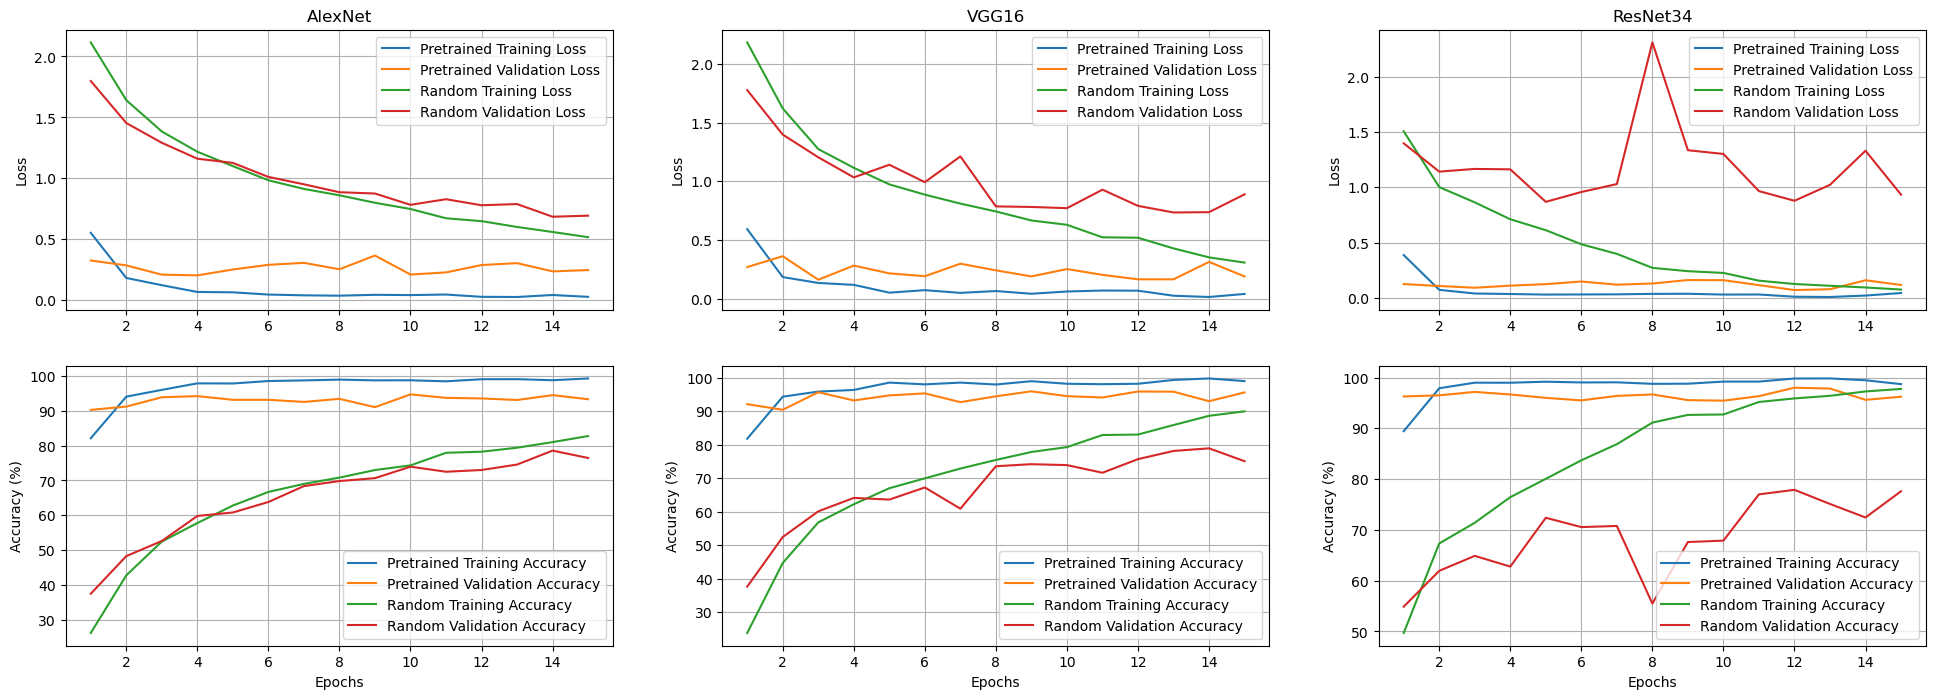

In [41]:
# Plot training and validation loss for AlexNet
fig, axes = plt.subplots(2, 3, figsize=(24, 8))
(ax1, ax3, ax5), (ax2, ax4, ax6) = axes

ax1.set_title("AlexNet")
ax1.plot(range(1, num_epochs+1), Alex_default_train_losses, label='Pretrained Training Loss')
ax1.plot(range(1, num_epochs+1), Alex_default_val_losses, label='Pretrained Validation Loss')
ax1.plot(range(1, num_epochs+1), Alex_random_train_losses, label='Random Training Loss')
ax1.plot(range(1, num_epochs+1), Alex_random_val_losses, label='Random Validation Loss')
ax1.grid()
ax1.set_ylabel('Loss')
ax1.legend()

# Plot training and validation accuracy for AlexNet
ax2.plot(range(1, num_epochs+1), Alex_default_train_accuracies, label='Pretrained Training Accuracy')
ax2.plot(range(1, num_epochs+1), Alex_default_val_accuracies, label='Pretrained Validation Accuracy')
ax2.plot(range(1, num_epochs+1), Alex_random_train_accuracies, label='Random Training Accuracy')
ax2.plot(range(1, num_epochs+1), Alex_random_val_accuracies, label='Random Validation Accuracy')
ax2.grid()
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()

ax3.set_title("VGG16")
ax3.plot(range(1, num_epochs+1), VGG16_default_train_losses, label='Pretrained Training Loss')
ax3.plot(range(1, num_epochs+1), VGG16_default_val_losses, label='Pretrained Validation Loss')
ax3.plot(range(1, num_epochs+1), VGG16_random_train_losses, label='Random Training Loss')
ax3.plot(range(1, num_epochs+1), VGG16_random_val_losses, label='Random Validation Loss')
ax3.grid()
ax3.set_ylabel('Loss')
ax3.legend()

ax4.plot(range(1, num_epochs+1), VGG16_default_train_accuracies, label='Pretrained Training Accuracy')
ax4.plot(range(1, num_epochs+1), VGG16_default_val_accuracies, label='Pretrained Validation Accuracy')
ax4.plot(range(1, num_epochs+1), VGG16_random_train_accuracies, label='Random Training Accuracy')
ax4.plot(range(1, num_epochs+1), VGG16_random_val_accuracies, label='Random Validation Accuracy')
ax4.grid()
ax4.set_xlabel('Epochs')
ax4.set_ylabel('Accuracy (%)')
ax4.legend()

ax5.set_title("ResNet34")
ax5.plot(range(1, num_epochs+1), ResNet34_default_train_losses, label='Pretrained Training Loss')
ax5.plot(range(1, num_epochs+1), ResNet34_default_val_losses, label='Pretrained Validation Loss')
ax5.plot(range(1, num_epochs+1), ResNet34_random_train_losses, label='Random Training Loss')
ax5.plot(range(1, num_epochs+1), ResNet34_random_val_losses, label='Random Validation Loss')
ax5.grid()
ax5.set_ylabel('Loss')
ax5.legend()

ax6.plot(range(1, num_epochs+1), ResNet34_default_train_accuracies, label='Pretrained Training Accuracy')
ax6.plot(range(1, num_epochs+1), ResNet34_default_val_accuracies, label='Pretrained Validation Accuracy')
ax6.plot(range(1, num_epochs+1), ResNet34_random_train_accuracies, label='Random Training Accuracy')
ax6.plot(range(1, num_epochs+1), ResNet34_random_val_accuracies, label='Random Validation Accuracy')
ax6.grid()
ax6.set_xlabel('Epochs')
ax6.set_ylabel('Accuracy (%)')
ax6.legend()

plt.show()

## Define model tester

In [ ]:
def perf_test(savename: str):
    model = torch.load(savename) # Loads up previously trained model from savefile
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_loss /= len(test_loader)
    test_accuracy = 100 * correct / total
    print(f"{savename}: Test loss = {round(test_loss, 2)} and Test accuracy = {round(test_accuracy, 2)}")
    return test_loss, test_accuracy

## Test models

In [ ]:
Alex_default_test_loss, Alex_default_test_accuracy = perf_test("AlexNet_default.pth")
Alex_random_test_loss, Alex_random_test_accuracy = perf_test("AlexNet_random.pth")
VGG16_default_test_loss, VGG16_default_test_accuracy = perf_test("VGG16_default.pth")
VGG16_random_test_loss, VGG16_random_test_accuracy = perf_test("VGG16_random.pth")
ResNet34_default_test_loss, ResNet34_default_test_accuracy = perf_test("ResNet34_default.pth")
ResNet34_random_test_loss, ResNet34_random_test_accuracy = perf_test("ResNet34_random.pth")

C:\Users\super\AppData\Local\Temp\ipykernel_31628\3415524912.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(savename)


AlexNet_default.pth: Test loss = 0.26 and Test accuracy = 93.0
AlexNet_random.pth: Test loss = 0.74 and Test accuracy = 75.33
VGG16_default.pth: Test loss = 0.17 and Test accuracy = 96.33
VGG16_random.pth: Test loss = 0.92 and Test accuracy = 72.78
ResNet34_default.pth: Test loss = 0.11 and Test accuracy = 96.72
ResNet34_random.pth: Test loss = 0.95 and Test accuracy = 76.11


## Test metrics display

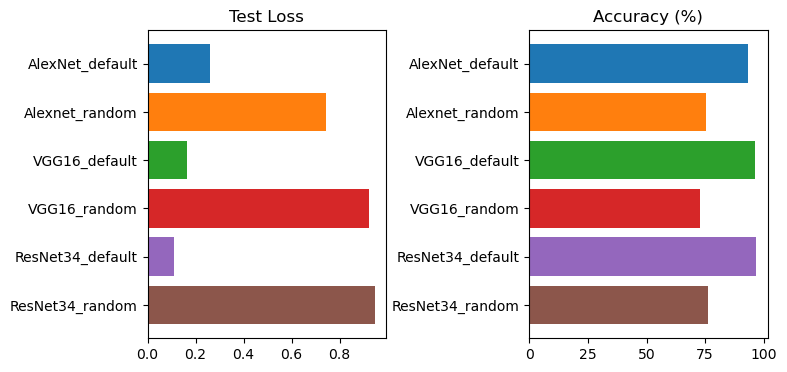

In [70]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
fig.subplots_adjust(wspace=0.6)

ax1.set_title("Test Loss")
ax1.invert_yaxis()
ax1.barh('AlexNet_default', Alex_default_test_loss)
ax1.barh('Alexnet_random', Alex_random_test_loss)
ax1.barh('VGG16_default', VGG16_default_test_loss)
ax1.barh('VGG16_random', VGG16_random_test_loss)
ax1.barh('ResNet34_default', ResNet34_default_test_loss)
ax1.barh('ResNet34_random', ResNet34_random_test_loss)

ax2.set_title('Accuracy (%)')
ax2.invert_yaxis()
ax2.barh('AlexNet_default', Alex_default_test_accuracy)
ax2.barh('Alexnet_random', Alex_random_test_accuracy)
ax2.barh('VGG16_default', VGG16_default_test_accuracy)
ax2.barh('VGG16_random', VGG16_random_test_accuracy)
ax2.barh('ResNet34_default', ResNet34_default_test_accuracy)
ax2.barh('ResNet34_random', ResNet34_random_test_accuracy)

plt.show()

## Make new training and validation datasets

In [52]:
color_jitter = transforms.ColorJitter(
    brightness=0.2,  # Adjust brightness by a factor of 0.8 to 1.2
    contrast=0.2,    # Adjust contrast by a factor of 0.8 to 1.2
    saturation=0.2,  # Adjust saturation by a factor of 0.8 to 1.2
    hue=0.1          # Adjust hue by a factor of -0.1 to 0.1
)

class Cutout(object):
    def __init__(self, mask_size, p):
        self.mask_size = mask_size
        self.p = p

    def __call__(self, img):
        if np.random.rand() > self.p:
            return img  # No cutout applied
        np_img = np.array(img)
        h, w = np_img.shape[:2]
        
        # Choose random location for the cutout
        y = np.random.randint(h)
        x = np.random.randint(w)
        
        # Apply mask
        y1 = np.clip(y - self.mask_size // 2, 0, h)
        y2 = np.clip(y + self.mask_size // 2, 0, h)
        x1 = np.clip(x - self.mask_size // 2, 0, w)
        x2 = np.clip(x + self.mask_size // 2, 0, w)
        
        np_img[y1:y2, x1:x2] = 0  # Mask area to black
        img = Image.fromarray(np_img)
        return img
    
transform_augmented = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 pixels (adjust as needed)
    color_jitter,                   # Add color jittering
    Cutout(mask_size=80, p=0.5),    # 32x32 mask with 50% chance of applying
    transforms.ToTensor(),          # Convert image to tensor
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())  # Normalize with calculated mean and std
])

In [53]:
batch_size = 32

In [54]:
train_dataset_augmented = ImageDataset(train_paths, train_labels, transform=transform_augmented)
val_dataset_augmented = ImageDataset(val_paths, val_labels, transform=transform_augmented)

In [55]:
train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader_augmented = DataLoader(val_dataset_augmented, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.054305553..0.8161464].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.009132773..1.1317383].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.054305553..0.653842].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.054305553..1.0956707].


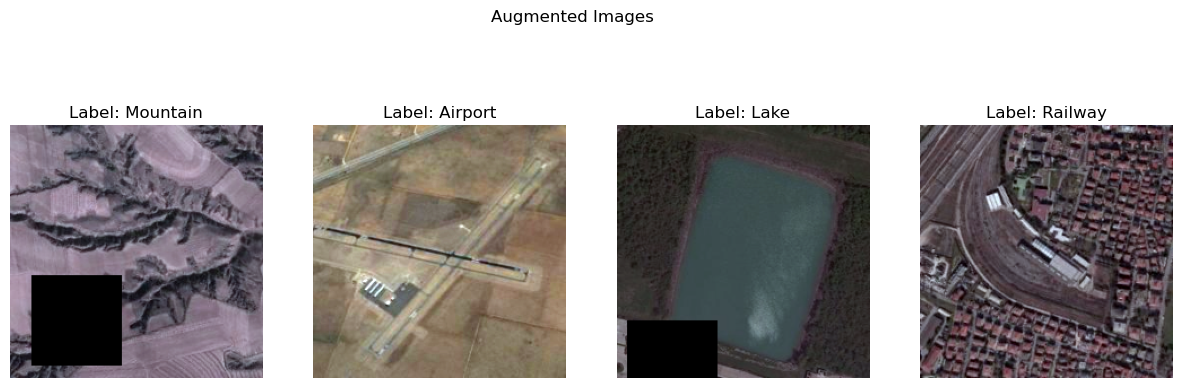

In [ ]:
# Create a DataLoader
visualize_loader = DataLoader(train_dataset_augmented, batch_size=4, shuffle=True)

# Fetch a batch of augmented images
images, label = next(iter(visualize_loader))

# Plot augmented images
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
fig.suptitle("Augmented Images")

for i in range(4):
    img = images[i].numpy().transpose((1, 2, 0))  # Rearrange dimensions for plt
    img = img * 0.1353 + 0.3781  # Unnormalize if necessary
    axes[i].imshow(img)
    axes[i].set_title(f"Label: {labels[label[i]]}")
    axes[i].axis('off')

plt.show()

## Early stopping

In [ ]:
class EarlyStopping:
    """
    Initializes the early stopping mechanism.

    Args:
        patience (int): Number of epochs to wait for improvement.
        delta (float): Minimum change in validation loss to qualify as improvement.

    """
    def __init__(self, patience, delta):
        self.patience = patience
        self.delta = delta
        self.best_score = None  # Tracks the best loss (last is better)
        self.early_stop = False  # Flag for early stopping
        self.counter = 0  # Counter for epochs without improvement
        self.best_loss = np.inf  # Best loss starts as infinity

    ''' special method that allows us to use the object as if it were a function. '''
    def __call__(self, val_loss, model):
        """
        Training should be stopped early based on validation loss.

        Args:
            val_loss (float): Current epoch's validation loss.
            model (torch.nn.Module): Model to save if validation loss improves.
        """
        score = -val_loss  # Loss is used as the score (last is better, so we negate it)

        # If this is the middle epoch or loss improved significantly
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score - self.delta:
            # No significant improvement (i..e, loss hasn't decreased enough)
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            # Improvement in loss
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0  # Reset the counter if loss improves

    def save_checkpoint(self, val_loss, model):
        """
        Save the model when validation loss improves.

        Args:
            val_loss (float): Current epoch's validation loss.
            model (torch.nn.Module): Model to save if validation loss improves.
        """
        if val_loss < self.best_loss:  # We save if loss decreased
            self.best_loss = val_loss
            checkpoint_name = "checkpoint.pth"
            torch.save(model, checkpoint_name)
            print(f'Model saved as {checkpoint_name}')

In [173]:
def early_stopping_training(model, epochs: int, savename: str):

    early_stopping = EarlyStopping(patience=5, delta=0.0001)

    # Initialize lists to store training and validation metrics
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Send selected model to device
    model = model.to(device)
    # Define optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader_augmented:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            ''' torch.max(outputs, 1): The torch.max() function returns the maximum
            value of all elements in the tensor along a specified dimension.
            (_) is used for variables that we don't need to use.'''
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_loss = running_loss / len(train_loader_augmented)
        # Append to the list
        train_losses.append(train_loss)
        train_accuracy = 100 * correct / total
        # Append to the list
        train_accuracies.append(train_accuracy)

        # .eval indicates that the model is used for prediction.
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader_augmented:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_loss /= len(val_loader_augmented)
        val_losses.append(val_loss)
        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
        early_stopping(val_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            os.rename("checkpoint.pth", savename)
            break
    return train_losses, val_losses, train_accuracies, val_accuracies

## Reloading fresh models for final tests

In [12]:
num_classes = 15
# Load pretrained AlexNet model
AlexNet = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)

# Load pretrained VGG16 model
vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

# Load pretrained ResNet34 model
ResNet34 = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)

# Change number of output classes to 15
AlexNet.classifier[6] = nn.Linear(AlexNet.classifier[6].in_features, num_classes)
vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, num_classes)
ResNet34.fc = nn.Linear(ResNet34.fc.in_features, num_classes)

In [205]:
# Increase number of epochs we probably wont reach beacause of early stopping.
num_epochs = 30
torch.cuda.empty_cache()

In [166]:
Alex_train_losses, Alex_val_losses, Alex_train_accuracies, Alex_val_accuracies = early_stopping_training(AlexNet, num_epochs, "AlexNet.pth")

Epoch 1/30, Train Loss: 0.6809, Train Accuracy: 77.79%, Val Loss: 0.3238, Val Accuracy: 89.44%
Model saved as checkpoint.pth
Epoch 2/30, Train Loss: 0.2920, Train Accuracy: 90.49%, Val Loss: 0.2979, Val Accuracy: 89.67%
Model saved as checkpoint.pth
Epoch 3/30, Train Loss: 0.2114, Train Accuracy: 93.26%, Val Loss: 0.2527, Val Accuracy: 91.39%
Model saved as checkpoint.pth
Epoch 4/30, Train Loss: 0.1435, Train Accuracy: 95.36%, Val Loss: 0.2632, Val Accuracy: 92.22%
EarlyStopping counter: 1 out of 5
Epoch 5/30, Train Loss: 0.1269, Train Accuracy: 95.52%, Val Loss: 0.2400, Val Accuracy: 92.61%
Model saved as checkpoint.pth
Epoch 6/30, Train Loss: 0.1213, Train Accuracy: 95.83%, Val Loss: 0.2573, Val Accuracy: 92.28%
EarlyStopping counter: 1 out of 5
Epoch 7/30, Train Loss: 0.0916, Train Accuracy: 97.01%, Val Loss: 0.2378, Val Accuracy: 92.94%
Model saved as checkpoint.pth
Epoch 8/30, Train Loss: 0.0889, Train Accuracy: 96.99%, Val Loss: 0.2875, Val Accuracy: 92.00%
EarlyStopping counter:

In [176]:
vgg16_train_losses, vgg16_val_losses, vgg16_train_accuracies, vgg16_val_accuracies = early_stopping_training(vgg16, num_epochs, "VGG16.pth")

Epoch 1/30, Train Loss: 0.7316, Train Accuracy: 77.77%, Val Loss: 0.3406, Val Accuracy: 91.06%
Model saved as checkpoint.pth
Epoch 2/30, Train Loss: 0.2999, Train Accuracy: 91.12%, Val Loss: 0.2542, Val Accuracy: 92.28%
Model saved as checkpoint.pth
Epoch 3/30, Train Loss: 0.2263, Train Accuracy: 93.45%, Val Loss: 0.2682, Val Accuracy: 91.72%
EarlyStopping counter: 1 out of 5
Epoch 4/30, Train Loss: 0.1371, Train Accuracy: 95.68%, Val Loss: 0.2303, Val Accuracy: 93.06%
Model saved as checkpoint.pth
Epoch 5/30, Train Loss: 0.1376, Train Accuracy: 95.69%, Val Loss: 0.2996, Val Accuracy: 91.72%
EarlyStopping counter: 1 out of 5
Epoch 6/30, Train Loss: 0.1303, Train Accuracy: 96.19%, Val Loss: 0.2942, Val Accuracy: 91.67%
EarlyStopping counter: 2 out of 5
Epoch 7/30, Train Loss: 0.1257, Train Accuracy: 96.31%, Val Loss: 0.3650, Val Accuracy: 91.06%
EarlyStopping counter: 3 out of 5
Epoch 8/30, Train Loss: 0.0934, Train Accuracy: 97.07%, Val Loss: 0.2009, Val Accuracy: 94.72%
Model saved as

In [177]:
ResNet34_train_losses, ResNet34_val_losses, ResNet34_train_accuracies, ResNet34_val_accuracies = early_stopping_training(ResNet34, num_epochs, "ResNet34.pth")

Epoch 1/30, Train Loss: 0.4675, Train Accuracy: 85.81%, Val Loss: 0.2218, Val Accuracy: 92.94%
Model saved as checkpoint.pth
Epoch 2/30, Train Loss: 0.1601, Train Accuracy: 94.99%, Val Loss: 0.1811, Val Accuracy: 94.33%
Model saved as checkpoint.pth
Epoch 3/30, Train Loss: 0.1056, Train Accuracy: 96.74%, Val Loss: 0.1439, Val Accuracy: 95.44%
Model saved as checkpoint.pth
Epoch 4/30, Train Loss: 0.0796, Train Accuracy: 97.62%, Val Loss: 0.1758, Val Accuracy: 94.72%
EarlyStopping counter: 1 out of 5
Epoch 5/30, Train Loss: 0.0813, Train Accuracy: 97.31%, Val Loss: 0.1504, Val Accuracy: 95.22%
EarlyStopping counter: 2 out of 5
Epoch 6/30, Train Loss: 0.0637, Train Accuracy: 98.13%, Val Loss: 0.1457, Val Accuracy: 96.11%
EarlyStopping counter: 3 out of 5
Epoch 7/30, Train Loss: 0.0744, Train Accuracy: 97.85%, Val Loss: 0.1570, Val Accuracy: 95.11%
EarlyStopping counter: 4 out of 5
Epoch 8/30, Train Loss: 0.0682, Train Accuracy: 97.71%, Val Loss: 0.1635, Val Accuracy: 95.06%
EarlyStopping 

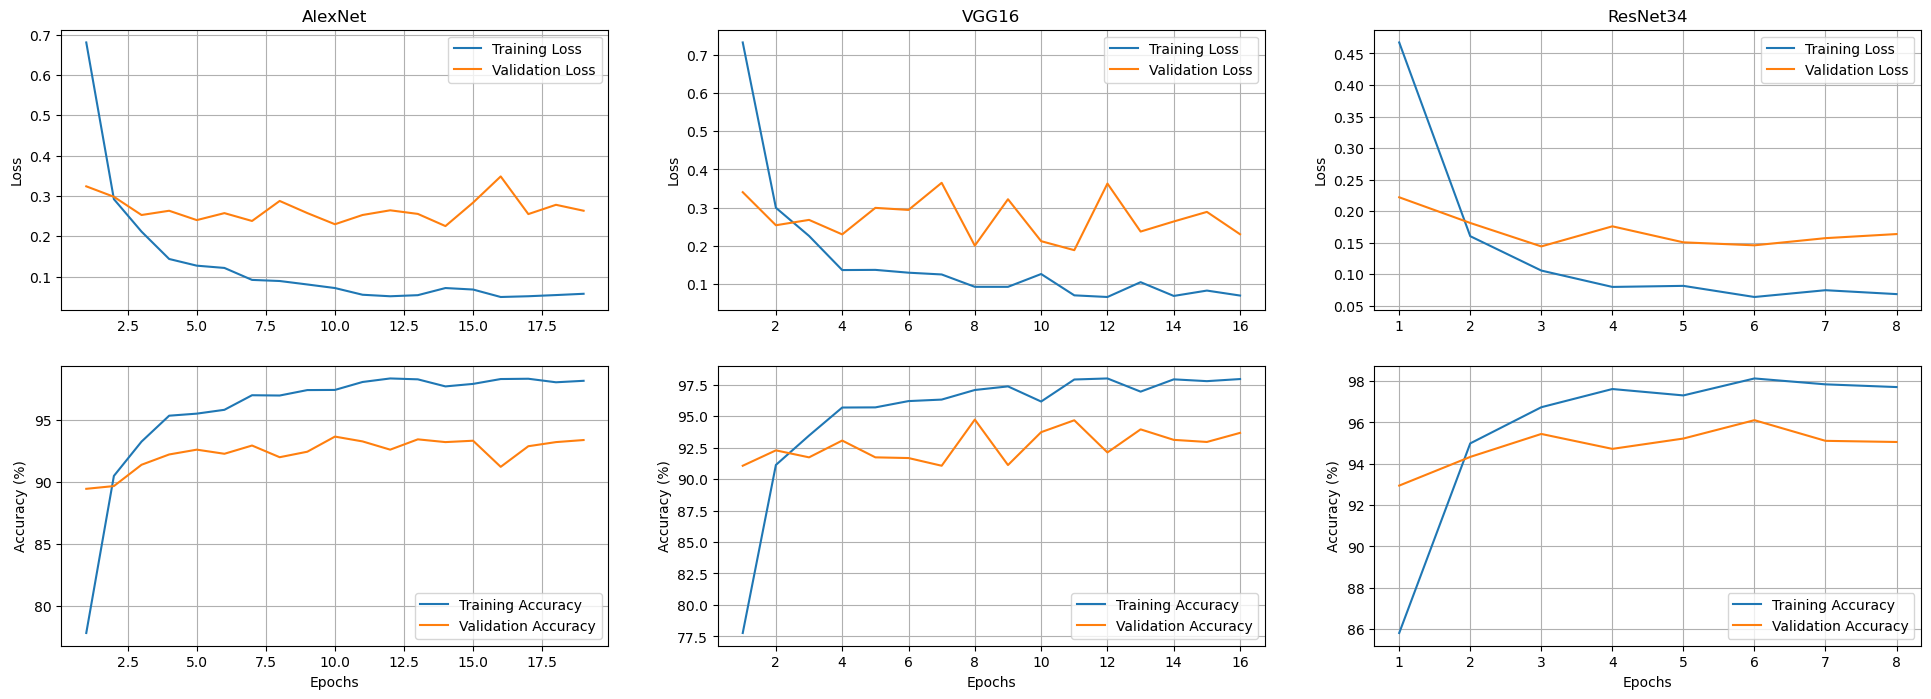

In [204]:
# Plot training and validation loss for AlexNet
fig, axes = plt.subplots(2, 3, figsize=(24, 8))
(ax1, ax3, ax5), (ax2, ax4, ax6) = axes

ax1.set_title("AlexNet")
ax1.plot(range(1, 19+1), Alex_train_losses, label='Training Loss')
ax1.plot(range(1, 19+1), Alex_val_losses, label='Validation Loss')
ax1.grid()
ax1.set_ylabel('Loss')
ax1.legend()

# Plot training and validation accuracy for AlexNet
ax2.plot(range(1, 19+1), Alex_train_accuracies, label='Training Accuracy')
ax2.plot(range(1, 19+1), Alex_val_accuracies, label='Validation Accuracy')
ax2.grid()
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()

ax3.set_title("VGG16")
ax3.plot(range(1, 16+1), vgg16_train_losses, label='Training Loss')
ax3.plot(range(1, 16+1), vgg16_val_losses, label='Validation Loss')
ax3.grid()
ax3.set_ylabel('Loss')
ax3.legend()

ax4.plot(range(1, 16+1), vgg16_train_accuracies, label='Training Accuracy')
ax4.plot(range(1, 16+1), vgg16_val_accuracies, label='Validation Accuracy')
ax4.grid()
ax4.set_xlabel('Epochs')
ax4.set_ylabel('Accuracy (%)')
ax4.legend()

ax5.set_title("ResNet34")
ax5.plot(range(1, 8+1), ResNet34_train_losses, label='Training Loss')
ax5.plot(range(1, 8+1), ResNet34_val_losses, label='Validation Loss')
ax5.grid()
ax5.set_ylabel('Loss')
ax5.legend()

ax6.plot(range(1, 8+1), ResNet34_train_accuracies, label='Training Accuracy')
ax6.plot(range(1, 8+1), ResNet34_val_accuracies, label='Validation Accuracy')
ax6.grid()
ax6.set_xlabel('Epochs')
ax6.set_ylabel('Accuracy (%)')
ax6.legend()

plt.show()

## Test state_dict

In [25]:
def perf_test_2(model):
    model = model.to(device)
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_loss /= len(test_loader)
    test_accuracy = 100 * correct / total
    print(f"Test loss = {round(test_loss, 2)} and Test accuracy = {round(test_accuracy, 2)}")
    return test_loss, test_accuracy

In [26]:
Alex_test_loss, Alex_test_accuracy = perf_test_2(AlexNet)
VGG16_test_loss, VGG16_test_accuracy = perf_test_2(vgg16)
ResNet34_test_loss, ResNet34_test_accuracy = perf_test_2(ResNet34)

Test loss = 0.23 and Test accuracy = 93.94
Test loss = 0.16 and Test accuracy = 95.0
Test loss = 0.12 and Test accuracy = 96.44


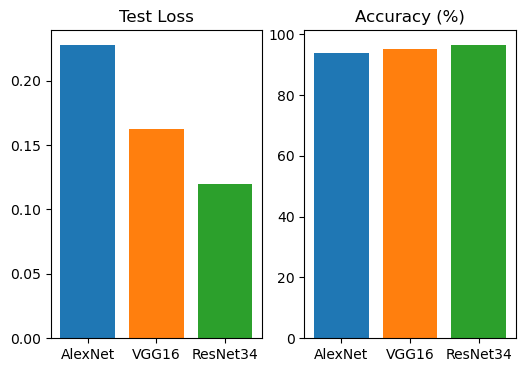

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))

ax1.set_title("Test Loss")
ax1.bar('AlexNet', Alex_test_loss)
ax1.bar('VGG16', VGG16_test_loss)
ax1.bar('ResNet34', ResNet34_test_loss)

ax2.set_title('Accuracy (%)')
ax2.bar('AlexNet', Alex_test_accuracy)
ax2.bar('VGG16', VGG16_test_accuracy)
ax2.bar('ResNet34', ResNet34_test_accuracy)

plt.show()

In [122]:
def add_gaussian_noise(images, mean=0.0, std=0.01):
    noise = torch.randn_like(images) * std + mean
    noisy_images = images + noise
    
    return torch.clamp(noisy_images, 0.0, 1.0)

def add_salt_and_pepper_noise(image_tensor, salt_prob=0.05, pepper_prob=0.05):
    batch_size, channels, height, width = image_tensor.shape
    
    # Generate random maps for salt and pepper noise
    salt_map = torch.rand(height, width) < salt_prob
    pepper_map = torch.rand(height, width) < pepper_prob
    
    # Add salt (white pixels)
    image_tensor[:,:,salt_map] = 1.0  # Set to white for salt noise (value = 1.0 for RGB)
    
    # Add pepper (black pixels)
    image_tensor[:,:,pepper_map] = 0.0  # Set to black for pepper noise (value = 0.0 for RGB)
    
    return image_tensor

In [29]:
def noise_test(model, noise):
    model = model.to(device)
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            inputs = noise(inputs) # Apply noise function

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_loss /= len(test_loader)
    test_accuracy = 100 * correct / total
    print(f"Test loss = {round(test_loss, 2)} and Test accuracy = {round(test_accuracy, 2)}")
    return test_loss, test_accuracy

In [ ]:
AlexNet.load_state_dict(torch.load("AlexNet.pth"))
vgg16.load_state_dict(torch.load("VGG16.pth"))
ResNet34.load_state_dict(torch.load("ResNet34.pth"))

In [38]:
Alex_gauss_loss, Alex_gauss_accu = noise_test(AlexNet, noise=lambda x: add_gaussian_noise(x))
VGG_gauss_loss, VGG_gauss_accu = noise_test(vgg16, noise=lambda x: add_gaussian_noise(x))
ResNet_gauss_loss, ResNet_gauss_accu = noise_test(ResNet34, noise=lambda x: add_gaussian_noise(x))

Test loss = 3.05 and Test accuracy = 44.89
Test loss = 3.4 and Test accuracy = 38.11
Test loss = 3.47 and Test accuracy = 36.44


In [123]:
Alex_sp_loss, Alex_sp_accu = noise_test(AlexNet, noise=lambda x: add_salt_and_pepper_noise(x))
VGG_sp_loss, VGG_sp_accu = noise_test(vgg16, noise=lambda x: add_salt_and_pepper_noise(x))
ResNet_sp_loss, ResNet_sp_accu = noise_test(ResNet34, noise=lambda x: add_salt_and_pepper_noise(x))

Test loss = 2.63 and Test accuracy = 60.67
Test loss = 2.76 and Test accuracy = 52.39
Test loss = 0.86 and Test accuracy = 76.94


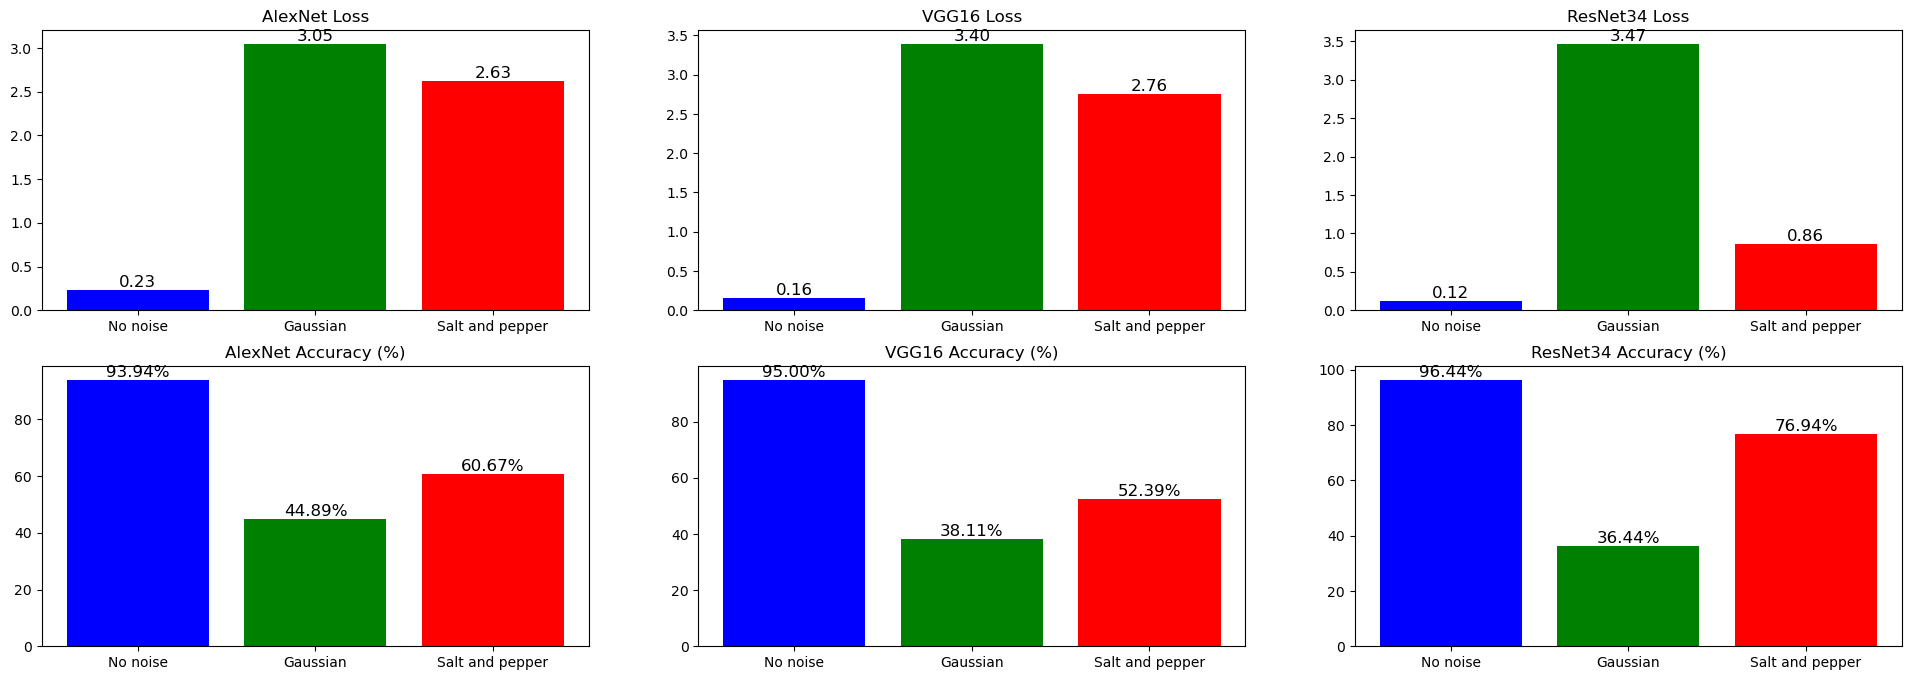

In [124]:
fig, axes = plt.subplots(2, 3, figsize=(24, 8))
(ax1, ax3, ax5), (ax2, ax4, ax6) = axes

# AlexNet Loss plot
ax1.set_title("AlexNet Loss")
bars1 = ax1.bar(
    ['No noise', 'Gaussian', 'Salt and pepper'], 
    [Alex_test_loss, Alex_gauss_loss, Alex_sp_loss],
    color=['blue', 'green', 'red']  # Assigning different colors
)
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', fontsize=12)

# AlexNet Accuracy plot
ax2.set_title('AlexNet Accuracy (%)')
bars2 = ax2.bar(
    ['No noise', 'Gaussian', 'Salt and pepper'], 
    [Alex_test_accuracy, Alex_gauss_accu, Alex_sp_accu],
    color=['blue', 'green', 'red']  # Assigning different colors
)
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}%', ha='center', va='bottom', fontsize=12)

# VGG16 Loss plot
ax3.set_title("VGG16 Loss")
bars3 = ax3.bar(
    ['No noise', 'Gaussian', 'Salt and pepper'], 
    [VGG16_test_loss, VGG_gauss_loss, VGG_sp_loss],
    color=['blue', 'green', 'red']  # Assigning different colors
)
for bar in bars3:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', fontsize=12)

# VGG16 Accuracy plot
ax4.set_title('VGG16 Accuracy (%)')
bars4 = ax4.bar(
    ['No noise', 'Gaussian', 'Salt and pepper'], 
    [VGG16_test_accuracy, VGG_gauss_accu, VGG_sp_accu],
    color=['blue', 'green', 'red']  # Assigning different colors
)
for bar in bars4:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}%', ha='center', va='bottom', fontsize=12)

# ResNet34 Loss plot
ax5.set_title("ResNet34 Loss")
bars5 = ax5.bar(
    ['No noise', 'Gaussian', 'Salt and pepper'], 
    [ResNet34_test_loss, ResNet_gauss_loss, ResNet_sp_loss],
    color=['blue', 'green', 'red']  # Assigning different colors
)
for bar in bars5:
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', fontsize=12)

# ResNet34 Accuracy plot
ax6.set_title('ResNet34 Accuracy (%)')
bars6 = ax6.bar(
    ['No noise', 'Gaussian', 'Salt and pepper'], 
    [ResNet34_test_accuracy, ResNet_gauss_accu, ResNet_sp_accu],
    color=['blue', 'green', 'red']  # Assigning different colors
)
for bar in bars6:
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}%', ha='center', va='bottom', fontsize=12)

plt.show()


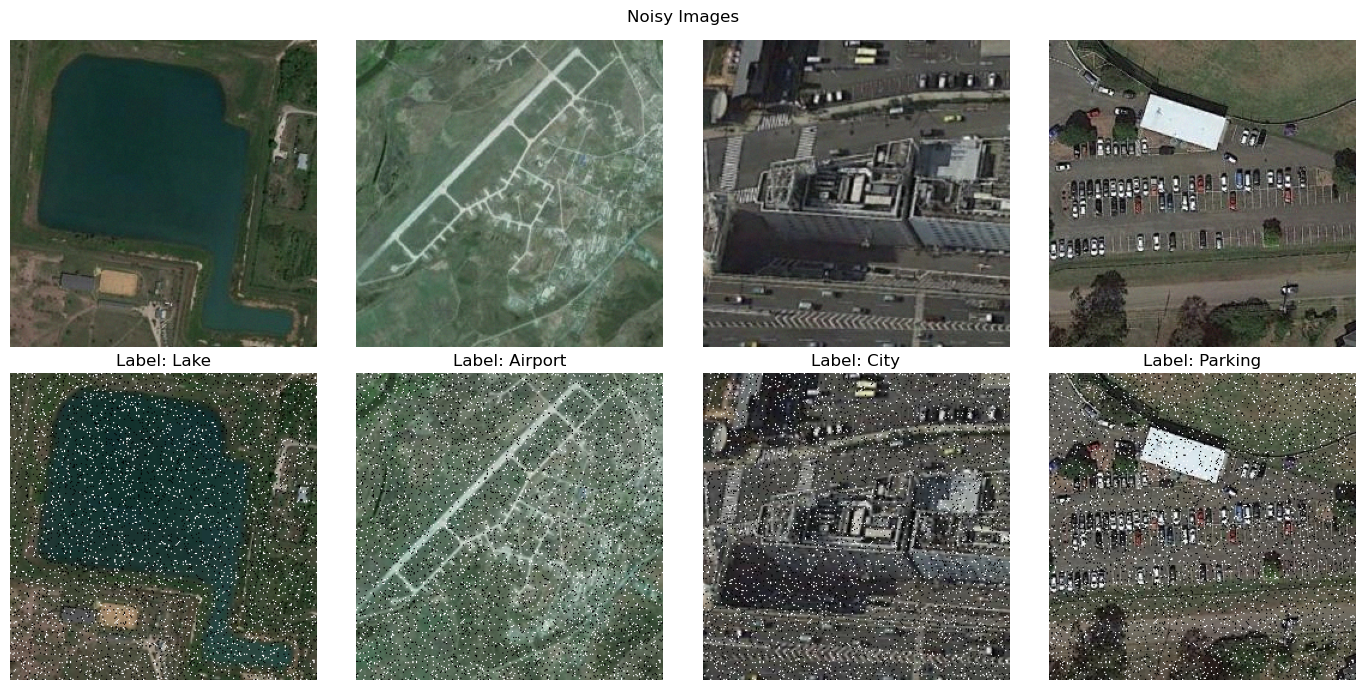

In [125]:
# Create a DataLoader
visualize_loader = DataLoader(temp_dataset, batch_size=4, shuffle=True)

# Fetch a batch of augmented images
images, label = next(iter(visualize_loader))
gauss = add_gaussian_noise(images)
sp = add_salt_and_pepper_noise(images)

# Plot augmented images
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
middle, last = axes
fig.suptitle("Noisy Images")

for i in range(4):
    img = gauss[i].numpy().transpose((1, 2, 0))  # Rearrange dimensions for plt
    middle[i].imshow(img)
    middle[i].axis('off')

for i in range(4):
    img = sp[i].numpy().transpose((1, 2, 0))  # Rearrange dimensions for plt
    last[i].imshow(img)
    last[i].set_title(f"Label: {categories[label[i]]}")
    last[i].axis('off')

plt.tight_layout()
plt.show()